# <center> **Vietnamese Traditional Music Classification (Deep Learning Approach)**</center>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
# Define root directory
root = '/content/drive/MyDrive/DATA/VNTM3'
folder_root = "/content/drive/MyDrive/DATA/mel-images"
dataset_root = "/content/drive/MyDrive/DATA/dataset"
train_root = "/content/drive/MyDrive/DATA/train"
val_root = "/content/drive/MyDrive/DATA/val"
test_root = "/content/drive/MyDrive/DATA/test"
checkpoint_filepath = '/content/drive/MyDrive/DATA/checkpoint'
saved_model_path = '/content/drive/MyDrive/DATA/model'
test_audio_path = "/content/drive/MyDrive/DATA/test_audio"

In [19]:
import os
import librosa as lb
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import random

In [20]:
os.listdir(root)

['hatxam', 'chauvan', 'cheo', 'cailuong', 'catru']

In [21]:
# Define variables for further use
type_list = {0: ["cailuong", "CaiLuong"], 1: ["catru", "Catru"], 2:["chauvan", "Chauvan"], 3: ["cheo", "Cheo"], 4: ["hatxam", "Xam"]}
class_list = {0: "cailuong", 1: "catru", 2:"chauvan", 3: "cheo", 4: "hatxam"}

## 1) **Data Preprocessing**

For each class, we create a dictionary which keys are the numerical order (index) of samples in the folder of that class, and value corresponding to the index is another dictionary containing necessary  properties sush as directory, sampling array, short-time fourier transfrom, spectrogram ...

Here is example of the dictionary of samplesin "cailuong" folder:



In this part, we create two dictionary for each class:
 - ```five_class_samples:``` Dictionary of 5 random samples of the class for the purpose of debugging and visualization.
 - ```class_samples:``` Dictionary all samples of the class.

### **Get directories**

In [22]:
# Function t
def load_dir_samples(root, type_index, samples_list, num_of_samples, mode):
    # Mode:
    #   - Random: Load random dir
    #   - All: Load all dir

    # Return:
    #   - Sample_list: Dictionary {index: {"dir": "/...."}}
    def padding(index):
        # Padding
        if 0 <= index < 10:
            index = "00" +str(index)
        elif 10 <= index < 100:
            index = "0" +str(index)
        return index
    for i in range(0, num_of_samples):
        if mode == "random": # Mode load random samples
            random_index = np.random.randint(0, 500)
            index = random_index
            samples_list[index] = {}  # For futher append values
            random_index = padding(random_index)
            samples_list[index]["dir"] = (os.path.join(root, type_list[type_index][0], type_list[type_index][1] + "." + str(random_index) + ".wav"))
        if mode == "all":  # Mode load all samples
            index = i
            samples_list[index] = {}
            i = padding(i)
            samples_list[index]["dir"] = os.path.join(root, type_list[type_index][0], type_list[type_index][1] + "." + str(i) + ".wav")
    return samples_list


#### Get random 5 samples directory and audio

In [23]:
# Get 5 samples of class "Cailuong"
five_cailuong_samples = load_dir_samples(root, 0, {}, 5, "random")
print(five_cailuong_samples)
# Take a sample
key = list(five_cailuong_samples.keys())
print("Sample id: {}".format(key[0]))
ipd.Audio(five_cailuong_samples[key[0]]["dir"])

{302: {'dir': '/content/drive/MyDrive/DATA/VNTM3/cailuong/CaiLuong.302.wav'}, 343: {'dir': '/content/drive/MyDrive/DATA/VNTM3/cailuong/CaiLuong.343.wav'}, 316: {'dir': '/content/drive/MyDrive/DATA/VNTM3/cailuong/CaiLuong.316.wav'}, 275: {'dir': '/content/drive/MyDrive/DATA/VNTM3/cailuong/CaiLuong.275.wav'}, 46: {'dir': '/content/drive/MyDrive/DATA/VNTM3/cailuong/CaiLuong.046.wav'}}
Sample id: 302


#### Get all samples directory

In [24]:
# Load all samples of class "cailuong"
nums_of_cailuong_samples = len(os.listdir(root+ "/cailuong"))
cailuong_samples = load_dir_samples(root, 0, {}, nums_of_cailuong_samples, mode = "all")
print(cailuong_samples)
len(cailuong_samples) # 500 samples

{0: {'dir': '/content/drive/MyDrive/DATA/VNTM3/cailuong/CaiLuong.000.wav'}, 1: {'dir': '/content/drive/MyDrive/DATA/VNTM3/cailuong/CaiLuong.001.wav'}, 2: {'dir': '/content/drive/MyDrive/DATA/VNTM3/cailuong/CaiLuong.002.wav'}, 3: {'dir': '/content/drive/MyDrive/DATA/VNTM3/cailuong/CaiLuong.003.wav'}, 4: {'dir': '/content/drive/MyDrive/DATA/VNTM3/cailuong/CaiLuong.004.wav'}, 5: {'dir': '/content/drive/MyDrive/DATA/VNTM3/cailuong/CaiLuong.005.wav'}, 6: {'dir': '/content/drive/MyDrive/DATA/VNTM3/cailuong/CaiLuong.006.wav'}, 7: {'dir': '/content/drive/MyDrive/DATA/VNTM3/cailuong/CaiLuong.007.wav'}, 8: {'dir': '/content/drive/MyDrive/DATA/VNTM3/cailuong/CaiLuong.008.wav'}, 9: {'dir': '/content/drive/MyDrive/DATA/VNTM3/cailuong/CaiLuong.009.wav'}, 10: {'dir': '/content/drive/MyDrive/DATA/VNTM3/cailuong/CaiLuong.010.wav'}, 11: {'dir': '/content/drive/MyDrive/DATA/VNTM3/cailuong/CaiLuong.011.wav'}, 12: {'dir': '/content/drive/MyDrive/DATA/VNTM3/cailuong/CaiLuong.012.wav'}, 13: {'dir': '/content

500

### **Sampling**

In [25]:
# Function to get signal sampling
def load_samples(samples_listdir):
    """
    Load and sampling
    Input: samples_listdir - Dictionary {index: {"dir": "/...."}}
    Output: samples_listdir - Dictionary {index: {"dir": "/....", "sampling": array}}
    """
    for index, sample in samples_listdir.items():
        file, sr = lb.load(sample["dir"])
        if len(samples_listdir[index]) == 1:  # Avoid adding multiple times
            samples_listdir[index]["sampling"] = file
    return samples_listdir

#### Sampling 5 random samples

In [26]:
five_cailuong_samples = load_samples(five_cailuong_samples)
print(five_cailuong_samples)

{302: {'dir': '/content/drive/MyDrive/DATA/VNTM3/cailuong/CaiLuong.302.wav', 'sampling': array([0.20535278, 0.16107178, 0.127594  , ..., 0.3258667 , 0.23919678,
       0.14364624], dtype=float32)}, 343: {'dir': '/content/drive/MyDrive/DATA/VNTM3/cailuong/CaiLuong.343.wav', 'sampling': array([ 0.27938843,  0.29864502,  0.24761963, ..., -0.13278198,
       -0.10665894, -0.06512451], dtype=float32)}, 316: {'dir': '/content/drive/MyDrive/DATA/VNTM3/cailuong/CaiLuong.316.wav', 'sampling': array([-0.07342529, -0.07516479, -0.07113647, ..., -0.07293701,
        0.05145264,  0.2055664 ], dtype=float32)}, 275: {'dir': '/content/drive/MyDrive/DATA/VNTM3/cailuong/CaiLuong.275.wav', 'sampling': array([-0.02929688, -0.03726196, -0.04629517, ..., -0.14608765,
       -0.3019104 , -0.45089722], dtype=float32)}, 46: {'dir': '/content/drive/MyDrive/DATA/VNTM3/cailuong/CaiLuong.046.wav', 'sampling': array([-0.00125122, -0.00491333, -0.00964355, ...,  0.00973511,
       -0.02294922, -0.09109497], dtype=fl

#### Sampling all samples

In [36]:
cailuong_samples = load_samples(cailuong_samples)


In [37]:
print(type(cailuong_samples))

<class 'dict'>


In [13]:
# import pickle

# def save_to_pkl(file_sample, file_name):
#     folder_path = "/content/drive/MyDrive/DATA/data_sample"

#     with open(f"{folder_path}/{file_name}", 'wb') as file:
#         pickle.dump(file_sample, file)

# save_to_pkl(cailuong_samples, "cailuong_samples.pkl")

In [31]:
# import pickle

# def load_pkl(file_path):
#     with open(file_path, 'rb') as file:
#         sample = pickle.load(file)
#     return sample

# cailuong_samples = load_pkl("/content/drive/MyDrive/DATA/data_sample/cailuong_samples.pkl")

### Waveform

In [38]:
def plot_waveform(samples, type_index, sr = 22050):
    """
    Waveform plot of samples
    """
    color = random.choice(["blue", "red", "yellow", "brown", "purple"])
    for index, sample in samples.items():
      plt.figure(figsize = (16, 5))
      lb.display.waveshow(y = sample["sampling"], sr = sr, color = color);
      plt.title("Sound Waves of sample {} of class {}".format(index, type_list[type_index][0]), fontsize = 23);


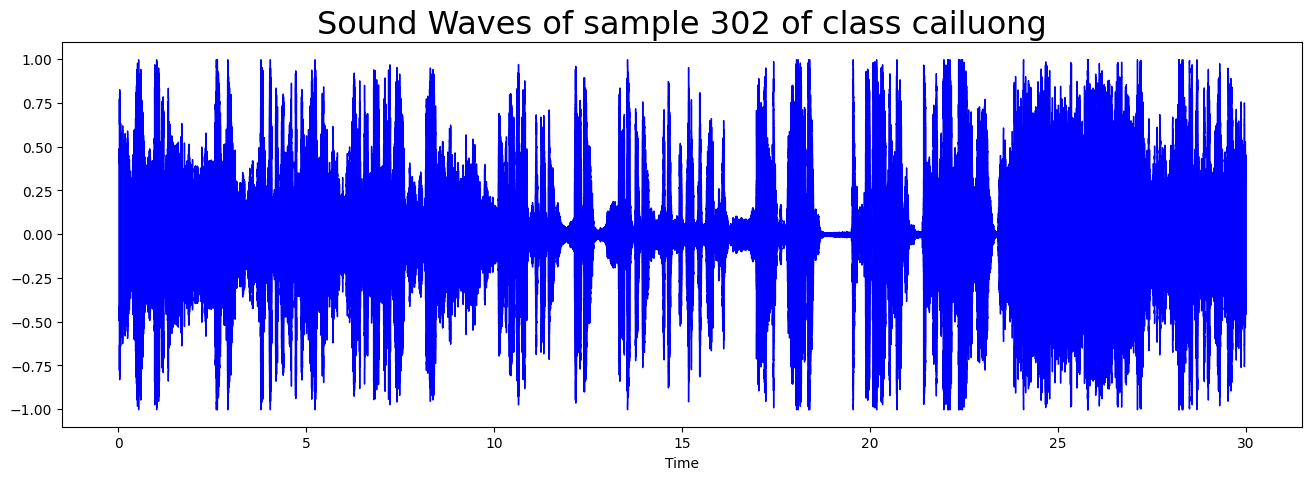

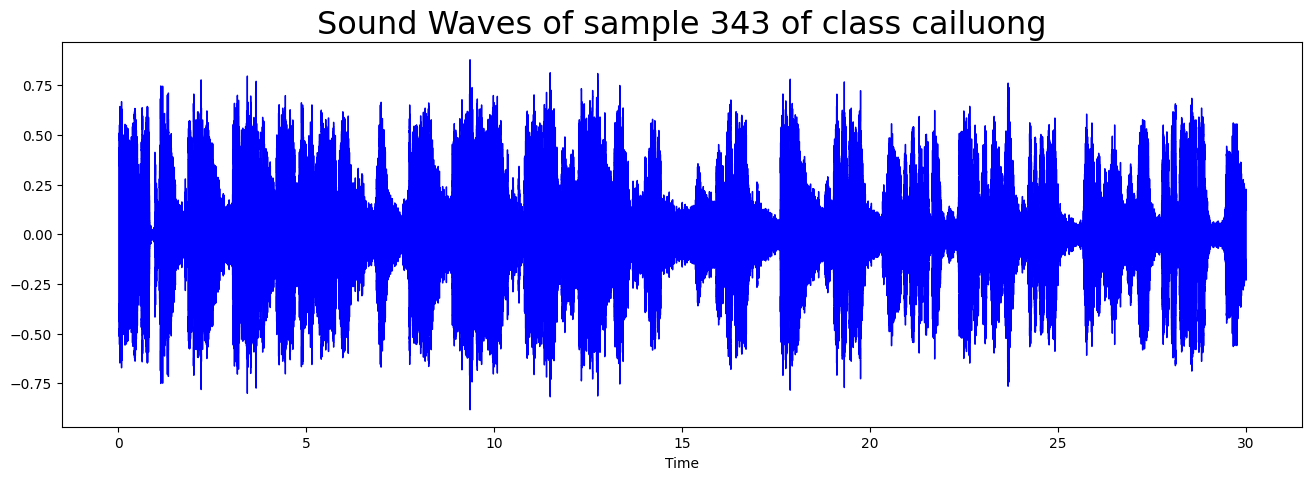

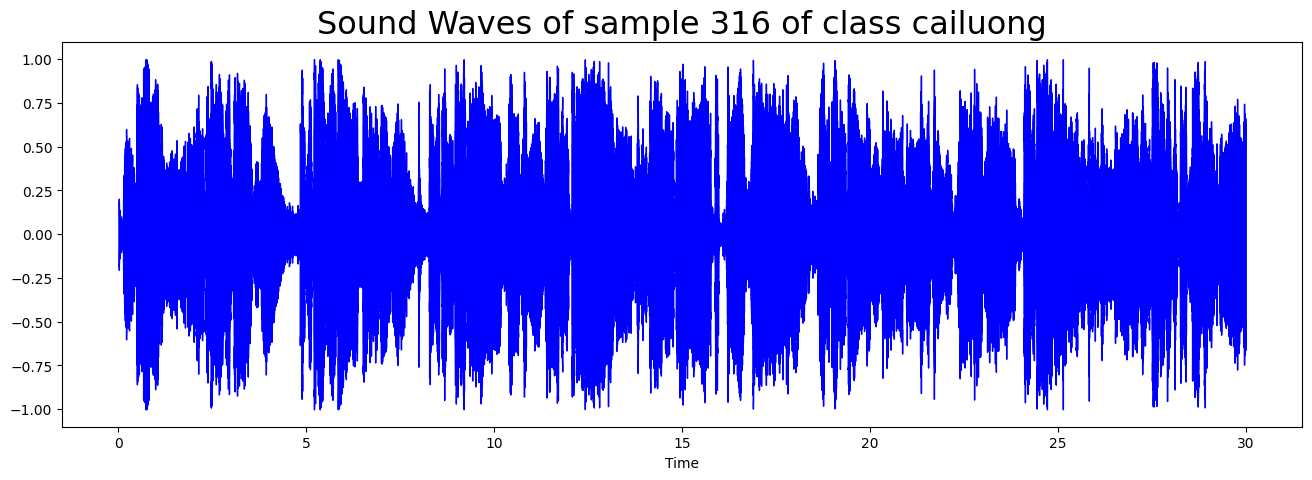

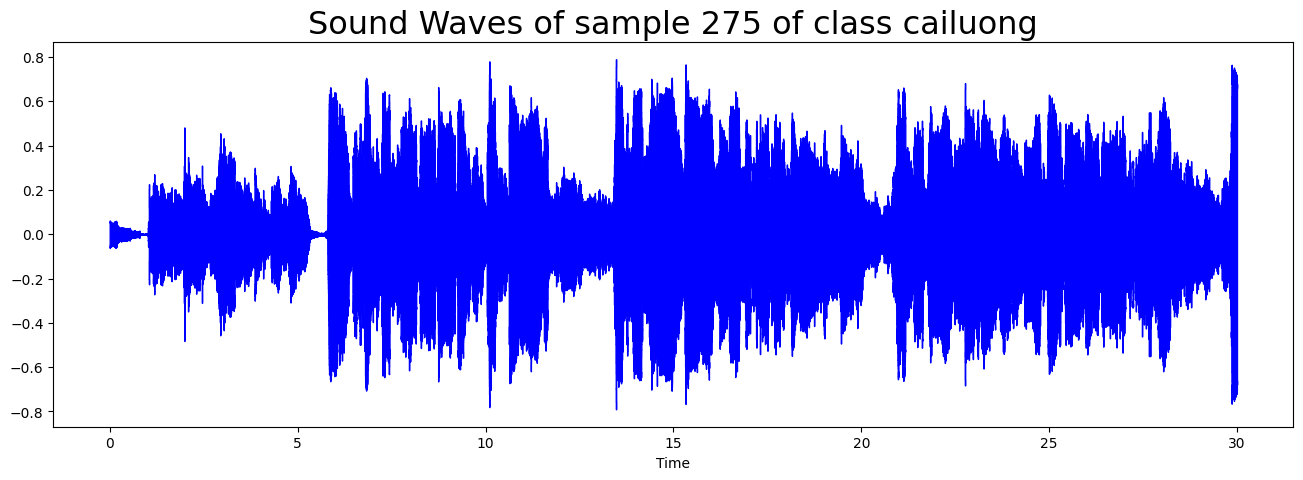

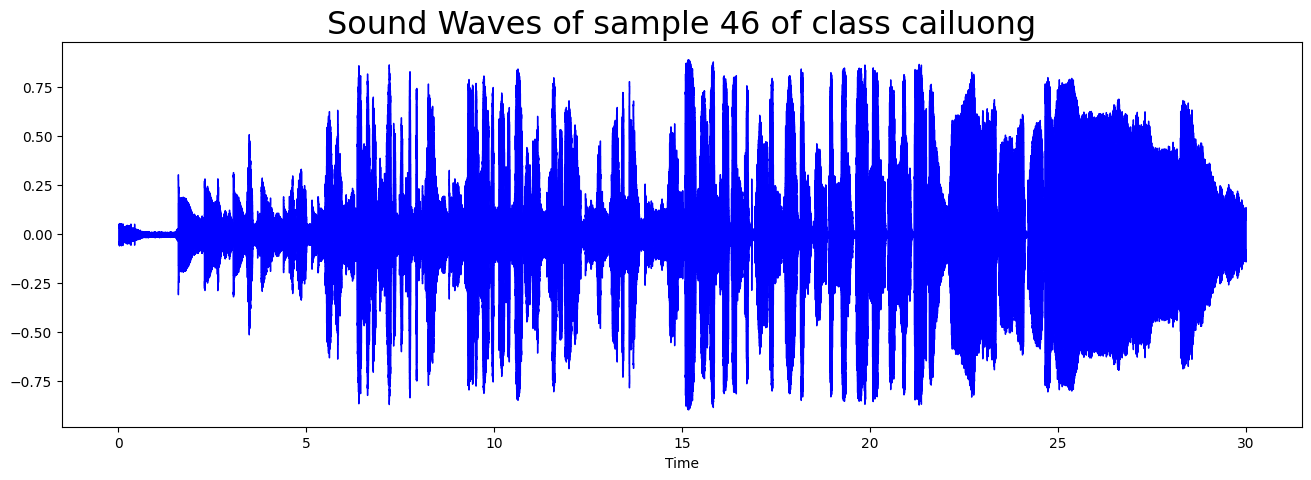

In [39]:
plot_waveform(five_cailuong_samples, 0)

### Short Time Fourier Transform

In [42]:
def get_fft(samples, n_fft = 2048, hop_length = 512):
    """
    Input: samples: {index: {"dir": "/..."}}
    Output: samples: {index: {"dir": "/...", "stft:" array}}
    """
    for index, item in samples.items():
        # Get STFT
        D = np.abs(lb.stft(item["sampling"], n_fft = n_fft, hop_length = hop_length))
        samples[index]["stft"] = D
    return samples

In [43]:
def plot_fft(samples, type_index):
    """
    Get frequency domain representation
    """
    for index, item in samples.items():
        plt.figure(figsize = (16, 6))
        plt.plot(item["stft"])
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.title("STFT of sample {} of class {}".format(index, type_list[type_index][0]))

#### Stft 5 random samples

In [44]:
five_cailuong_samples = get_fft(five_cailuong_samples)

#### Stft all samples

In [45]:
cailuong_samples = get_fft(cailuong_samples)

### Spectrogram

In [46]:
def plot_spectrogram(samples, type_index, HOP_LENGTH = 512):
  """
  Plot spectrogram
  """
  for index, item in samples.items():
      DB = lb.amplitude_to_db(item["stft"], ref = np.max)
      plt.figure(figsize = (25, 10))
      lb.display.specshow(DB, hop_length= HOP_LENGTH, x_axis = "time", y_axis = "log")
      plt.title("Spectrogram of sample {} of class {}".format(index, type_list[type_index][0]), fontsize = 20)
      plt.colorbar()

In [47]:
plot_spectrogram(five_cailuong_samples, 0)

Output hidden; open in https://colab.research.google.com to view.

### Mel-Spectrogram

In [49]:
def get_mel_spectrogram(samples, type_index, sr = 22050):
    """
    Get log-mel-spectrogram (db)
    Input: {index: {"dir": "/...", "stft": array, }}
    Output: {index: {"dir": "/...", "stft": array, "mel-spec-db": array}}
    """
    for index, item in samples.items():
        S = lb.feature.melspectrogram(y = item["sampling"], sr=sr)
        S_db = lb.amplitude_to_db(S, ref=np.max)
        samples[index]["mel-spec-db"] = S_db
    return samples

#### Mel-spec for 5 random samples

In [50]:
five_cailuong_samples = get_mel_spectrogram(five_cailuong_samples, 0)

In [51]:
def plot_mel_spectrogram(samples, type_index, sr = 22050, HOP_LENGTH = 512):
    """
    Plot log-mel-spectrogram
    """
    for index, item in samples.items():
        S_DB = item["mel-spec-db"]
        plt.figure(figsize = (16, 6))
        lb.display.specshow(S_DB, sr=sr, hop_length = HOP_LENGTH, x_axis = 'time', y_axis = 'log')
        plt.colorbar();
        plt.title("Mel Spectrogram of sample {} of class {}".format(index, type_list[type_index][0]), fontsize = 20)

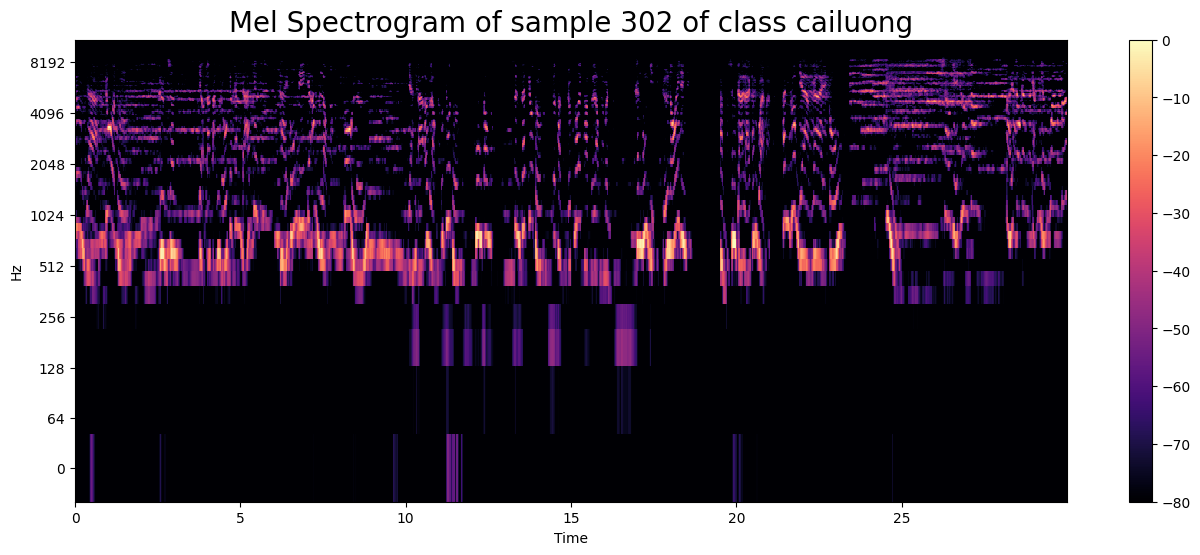

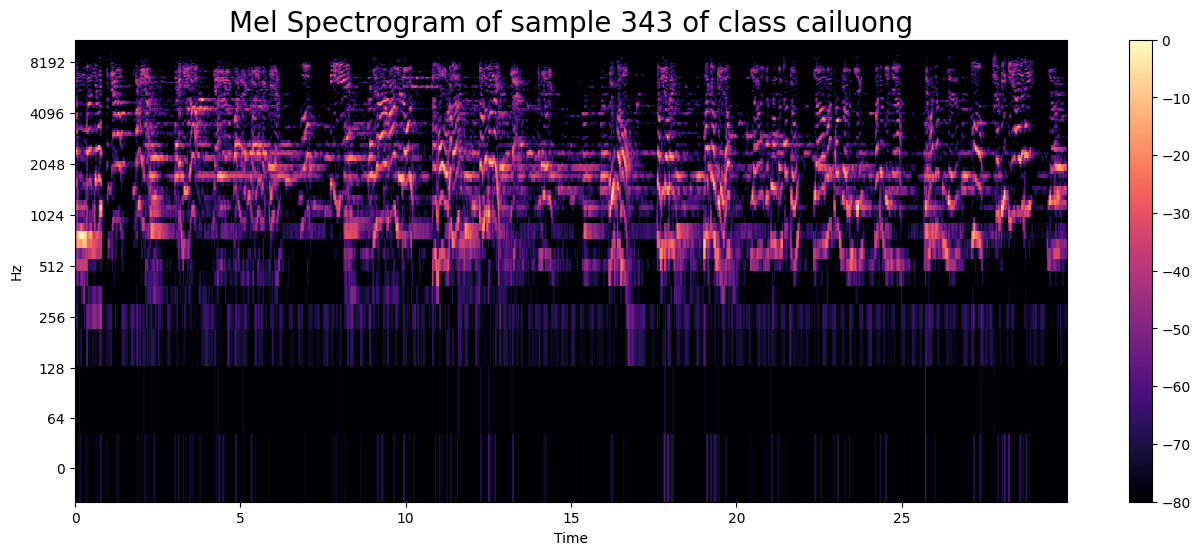

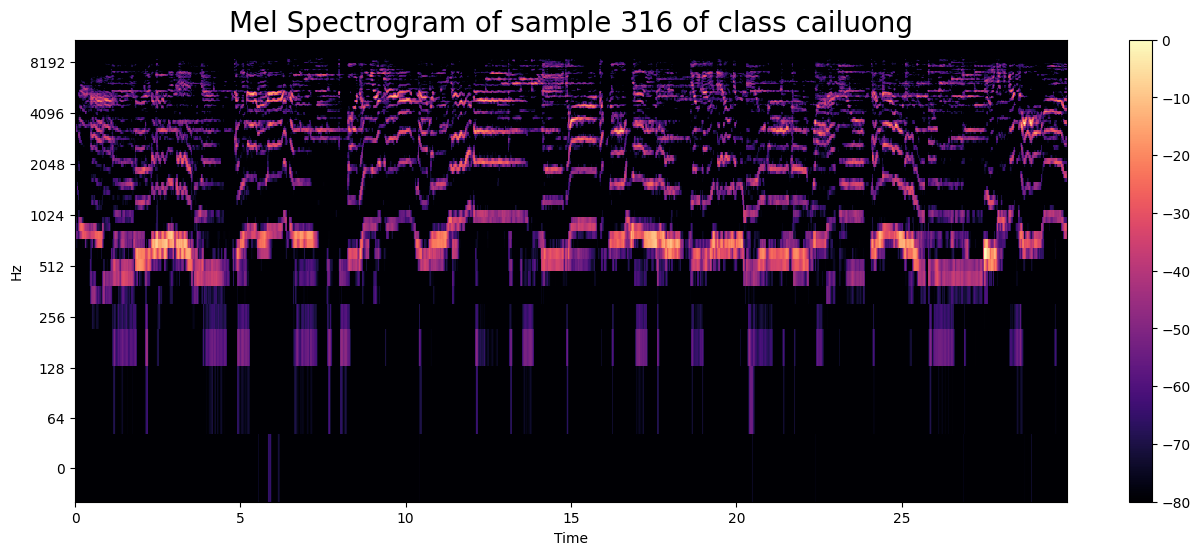

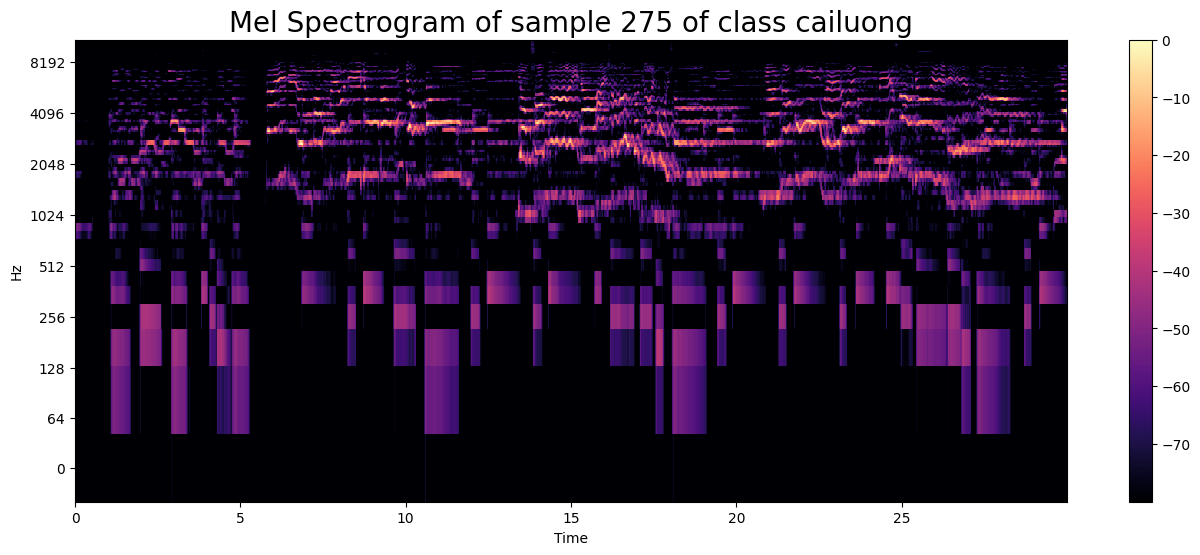

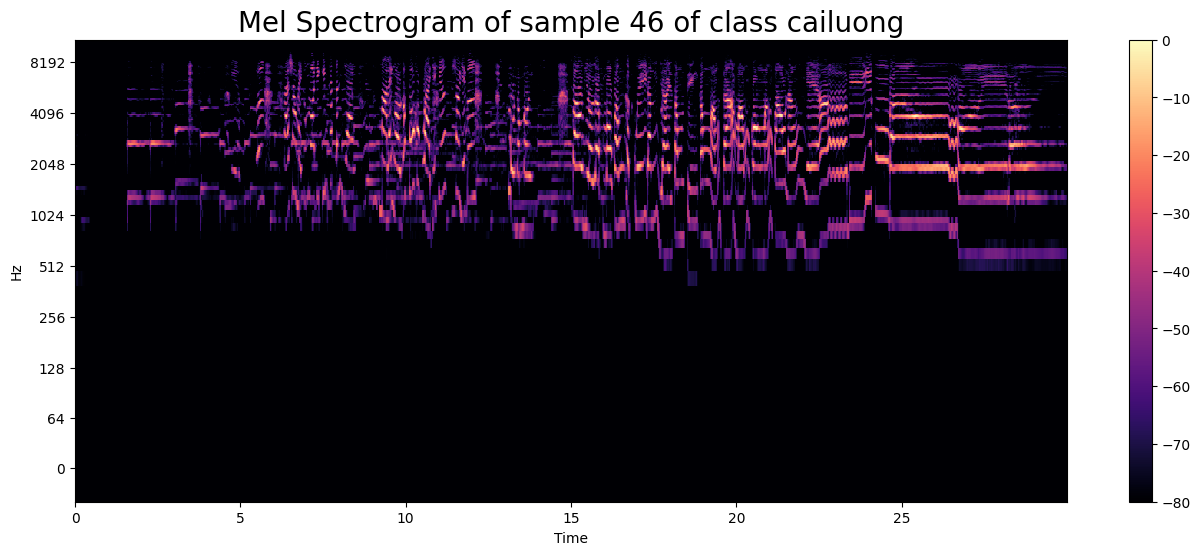

In [52]:
plot_mel_spectrogram(five_cailuong_samples, 0)

#### Mel-spectrogram all samples

In [53]:
cailuong_samples = get_mel_spectrogram(cailuong_samples, 0)

In [54]:
cailuong_samples[0]["mel-spec-db"].shape

(128, 1292)

### Save mel-spectrogram for images classification

In [55]:
save_root = "/content/drive/MyDrive/DATA"
if not os.path.exists(save_root + "/mel-images"):
    os.makedirs(save_root + "/mel-images")
save_root += "/mel-images"

In [56]:
def save_mel_spec(samples, root, type_index):
    """
    save log-mel-spec
    After running, images of a class will be saved in : root/class/file_name.png
    """
    for index, item in samples.items():
        S_db = item["mel-spec-db"]
        folder_root = str(root) + "/{}".format(type_list[type_index][0])
        if not os.path.exists(folder_root):
            os.makedirs(folder_root)
        # Get file name from fir
        file_name = item["dir"].split("/")[-1][:-4]
        plt.imsave(folder_root + "/{}".format(file_name) + ".png", S_db)

In [57]:
# Save "cailuong" mel-spectrogram at "/content/drive/MyDrive/DATA/mel-images/cailuong
save_mel_spec(cailuong_samples, save_root, 0)